# Langgraph flow

## Importing libarries

In [1]:
from typing_extensions import TypedDict
from typing import Literal

from langgraph.graph import StateGraph, START, END
import json


## LangGraph state class

In [2]:
# Utility Functions
class TypedDictState(TypedDict):
    state: str
    email: str
    classification: Literal["job_status", "online_meet", "other", "job_and_meet"]
    job_details: dict
    tracker_update: Literal["Successful", "Failed"]
    meet_request_details: dict
    meet_details: dict
    meet_link_sent: Literal["Successful", "Failed"]
    is_both_job_and_meet: bool

## Email Classification and Routing functions

In [3]:
def classify_email(state: TypedDictState) -> dict:
    """
    This function reads the email, classifies it, and updates the state.
    """
    print("---CLASSIFYING EMAIL---")
    email = state.get('email')

    if email == "job_and_meet":
        classification = "job_status"
        is_both_job_and_meet = True
    elif email == "job":
        classification = "job_status"
        is_both_job_and_meet = False
    elif email == "meet":
        classification = "online_meet"
        is_both_job_and_meet = False
    elif email == "other":
        classification = "other"
        is_both_job_and_meet = False
    
    return {"classification": classification, "is_both_job_and_meet": is_both_job_and_meet}

def route_after_classification(state: TypedDictState) -> Literal["job_status", "online_meet", "other"]:
    """
    Routes to the correct path based on the email classification stored in the state.
    """
    print(f"Routing to: {state['classification']}")
    return state["classification"]

In [4]:
def route_after_job_tracker(state: TypedDictState) -> Literal["online_meet", "__end__"]:
    """
    Routes to the correct path based on the is_both_job_and_meet flag in the state.
    """
    if state["is_both_job_and_meet"]:
        print("Routing to: online_meet path from job_status flow")
        return "online_meet"
    else:
        print("Ending flow after job status update")
        return "__end__"


## Job tracker flow

In [5]:
def job_status(state: TypedDictState) -> dict:
    """A placeholder node representing the job_status check step."""
    print("---IN JOB STATUS PATH---")
    return {}

def identify_job_details(state: TypedDictState):
    print("This function reads the email to extract job title, company name and job status")
    return {"job_details": {"title": "Data Scientist", "company": "Google", "status": "applied"}, "state": "Job details extracted"}

def update_tracker(state: TypedDictState):
    print("This function updated the tracker with extracted job details")
    return {"tracker_update": "Successful", "state": "Tracker update successful"}

In [6]:
def route_after_job_tracker(state: TypedDictState) -> Literal["online_meet", "__end__"]:
    """
    Routes to the correct path based on the is_both_job_and_meet flag in the state.
    """
    if state.get("is_both_job_and_meet"):
        print("Routing to: online_meet path from job_status flow")
        return "online_meet"
    else:
        print("Ending flow after job status update")
        return "__end__"

## Online Meet scheduling flow

In [7]:
def online_meet(state: TypedDictState) -> dict:
    """A placeholder node representing the online_meet check step."""
    print("---IN ONLINE MEET PATH---")
    return {}

def identify_meet_timings(state: TypedDictState):
    print("This function reads the email to extract online meet requested date, time, duration")
    return {"meet_request_details": {"requested_by": "johndoe@gmail.com", "date": "2025-07-13", "time": "9:00", "duration": "00:30"}, "state": "meeting request details extracted"}

def create_meet(state: TypedDictState):
    print("This function is to create online meet based on identified details")
    return {"meet_details": {"meet_link": "abcd link"}, "state": "meet link created"}

def send_meet_link(state: TypedDictState):
    print("This function is to draft and send email including meet link")
    return {"meet_link_sent": "Successful", "state": "meet link sent"}

## Other flow

In [8]:
def other(state: TypedDictState):
    print("---IN OTHER PATH---")
    return {"state": "Other flow triggered"}

## Building LangGraph

In [9]:
# Build the LangGraph
graph_builder = StateGraph(TypedDictState)

# Graph Nodes
graph_builder.add_node("classify_email", classify_email)
graph_builder.add_node("job_status", job_status)
graph_builder.add_node("online_meet", online_meet)
graph_builder.add_node("other", other)

graph_builder.add_node("identify_job_details", identify_job_details)
graph_builder.add_node("update_tracker", update_tracker)

graph_builder.add_node("identify_meet_timings", identify_meet_timings)
graph_builder.add_node("create_meet", create_meet)
graph_builder.add_node("send_meet_link", send_meet_link)

# Graph Edges
graph_builder.add_edge(START, "classify_email")
graph_builder.add_conditional_edges("classify_email", route_after_classification)

graph_builder.add_edge("job_status", "identify_job_details")
graph_builder.add_edge("identify_job_details", "update_tracker")
graph_builder.add_conditional_edges(
    "update_tracker",
    route_after_job_tracker,
    {
        "online_meet": "online_meet",
        "__end__": END
    }
)

graph_builder.add_edge("online_meet", "identify_meet_timings")
graph_builder.add_edge("identify_meet_timings", "create_meet")
graph_builder.add_edge("create_meet", "send_meet_link")
graph_builder.add_edge("send_meet_link", END)

graph_builder.add_edge("other", END)

## Creating Graph and Displaying

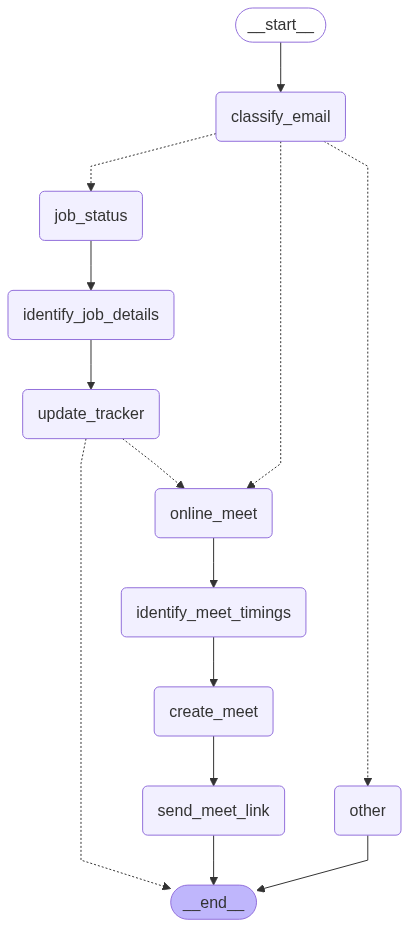

In [10]:
# Compile the graph
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("gone")
    pass

## Testing LangGraph

In [11]:
print("Invoking with 'job' email...")
graph.invoke({"email": "job"})

Invoking with 'job' email...
---CLASSIFYING EMAIL---
Routing to: job_status
---IN JOB STATUS PATH---
This function reads the email to extract job title, company name and job status
This function updated the tracker with extracted job details
Ending flow after job status update


{'state': 'Tracker update successful',
 'email': 'job',
 'classification': 'job_status',
 'job_details': {'title': 'Data Scientist',
  'company': 'Google',
  'status': 'applied'},
 'tracker_update': 'Successful',
 'is_both_job_and_meet': False}

In [12]:
print("\nInvoking with 'meet' email...")
graph.invoke({"email": "meet"})


Invoking with 'meet' email...
---CLASSIFYING EMAIL---
Routing to: online_meet
---IN ONLINE MEET PATH---
This function reads the email to extract online meet requested date, time, duration
This function is to create online meet based on identified details
This function is to draft and send email including meet link


{'state': 'meet link sent',
 'email': 'meet',
 'classification': 'online_meet',
 'meet_request_details': {'requested_by': 'johndoe@gmail.com',
  'date': '2025-07-13',
  'time': '9:00',
  'duration': '00:30'},
 'meet_details': {'meet_link': 'abcd link'},
 'meet_link_sent': 'Successful',
 'is_both_job_and_meet': False}

In [13]:
print("\nInvoking with 'other' email...")
graph.invoke({"email": "other"})


Invoking with 'other' email...
---CLASSIFYING EMAIL---
Routing to: other
---IN OTHER PATH---


{'state': 'Other flow triggered',
 'email': 'other',
 'classification': 'other',
 'is_both_job_and_meet': False}

In [14]:
print("\nInvoking with 'job_and_meet' email...")
graph.invoke({"email": "job_and_meet"})


Invoking with 'job_and_meet' email...
---CLASSIFYING EMAIL---
Routing to: job_status
---IN JOB STATUS PATH---
This function reads the email to extract job title, company name and job status
This function updated the tracker with extracted job details
Routing to: online_meet path from job_status flow
---IN ONLINE MEET PATH---
This function reads the email to extract online meet requested date, time, duration
This function is to create online meet based on identified details
This function is to draft and send email including meet link


{'state': 'meet link sent',
 'email': 'job_and_meet',
 'classification': 'job_status',
 'job_details': {'title': 'Data Scientist',
  'company': 'Google',
  'status': 'applied'},
 'tracker_update': 'Successful',
 'meet_request_details': {'requested_by': 'johndoe@gmail.com',
  'date': '2025-07-13',
  'time': '9:00',
  'duration': '00:30'},
 'meet_details': {'meet_link': 'abcd link'},
 'meet_link_sent': 'Successful',
 'is_both_job_and_meet': True}